<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_fault_network/blob/main/report_files/12_Fix%20BL%20and%20Abattoirs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_faults
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.4
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM =  r"./data/DEM.tif"

In [4]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [5]:
# import the oris and datas
updated_data = pd.read_csv("./data/LoopStructural_data/updated_data.csv")
updated_oris = pd.read_csv("./data/LoopStructural_data/updated_oris.csv")

In [6]:
updated_data = updated_data.reset_index(drop=True)
updated_oris = updated_oris.reset_index(drop=True)

In [7]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [8]:
# remove BL, Abattoirs and Boorara from main dfs

In [9]:
updated_data = updated_data.drop(updated_data[updated_data['fault_name']=='Boulder Lefroy Fault'].index)
updated_data = updated_data.drop(updated_data[updated_data['fault_name']=='Abattoir West Fault'].index)
updated_data = updated_data.drop(updated_data[updated_data['fault_name']=='Abattoir East Fault'].index)

In [10]:
updated_oris = updated_oris.drop(updated_oris[updated_oris['fault_name']=='Boulder Lefroy Fault'].index)
updated_oris = updated_oris.drop(updated_oris[updated_oris['fault_name']=='Abattoir West Fault'].index)
updated_oris = updated_oris.drop(updated_oris[updated_oris['fault_name']=='Abattoir East Fault'].index)

In [11]:
BL_pts = gpd.read_file(os.path.join(path_shp, "BL_pts_elevation_2.shp"))
BL_pts = pd.DataFrame({'X': BL_pts.geometry.x, 
              'Y': BL_pts.geometry.y, 
              'Z': BL_pts.DEM_main})

BL_pts['fault_name'] = "Boulder Lefroy Fault"

In [12]:
BL_seismic = gpd.read_file(os.path.join(path_seismic, "Boulder_Lefroy_cropped.shp"))

BL_seismic = BL_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
BL_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

BL_seismic['fault_name'] = BL_seismic['fault_name'].str.replace('Boulder-Lefroy Shear Zone', "Boulder Lefroy Fault")

# drop the values above zero
BL_seismic = BL_seismic.drop(BL_seismic[BL_seismic['Z']>0].index)

In [13]:
gs = []

tmpA = []
tmpB = []

xs = BL_seismic['X'].to_numpy()
ys = BL_seismic['Y'].to_numpy()
zs = BL_seismic['Z'].to_numpy()

meanX = BL_pts['X'].mean()
meanY = BL_pts['Y'].mean()
meanZ = zs.mean() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Boulder Lefroy Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [14]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_oris, ori])

In [15]:
updated_data = pd.concat([updated_data, BL_seismic, BL_pts])

In [16]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [17]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)
# model.nsteps = [150, 250, 50]
model.data = processor.data

model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM)  

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, 
                           regularization = [5,5,5])

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 3                     geological features that need to be interpolated



  0%|          | 0/3 [00:00<?, ?it/s]

Model update took: 8.1711106300354 seconds


Object exists: Boulder Lefroy Fault_value_cp
Object exists: Boulder Lefroy Fault_value_cp



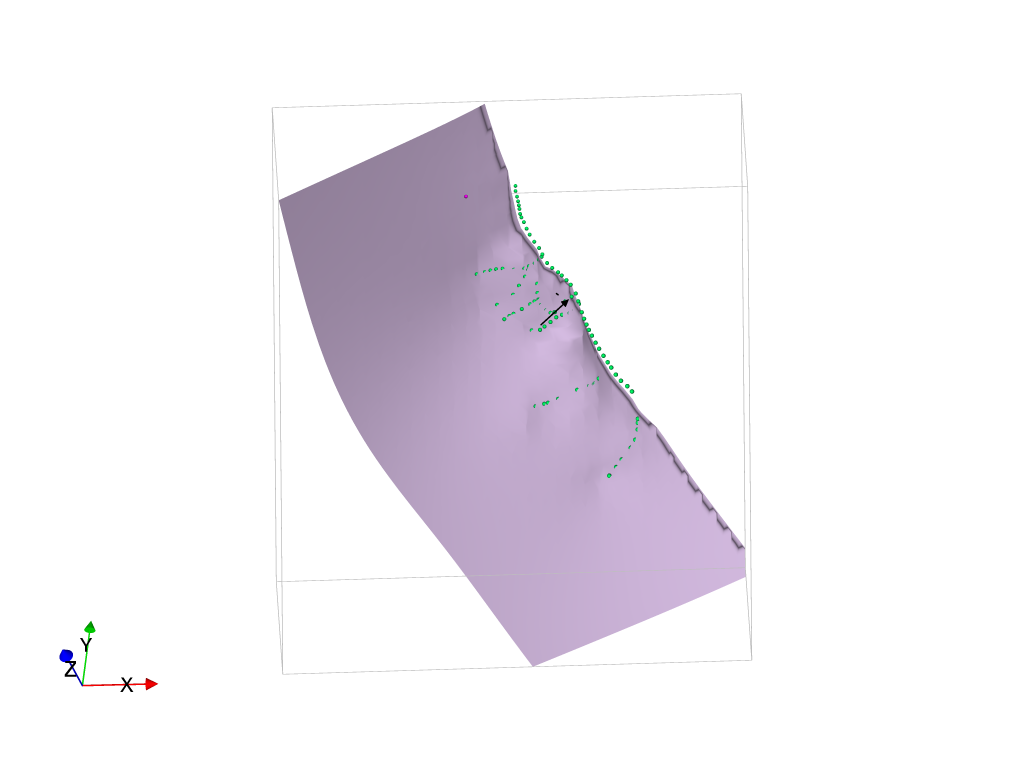

In [18]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_data(model['Boulder Lefroy Fault'], vectors = True)

view.rotation = [-36.196144104003906, -1.6681442260742188, 1.7141367197036743]
view.display()

# Add Abattoir East 

In [49]:
AE_pts = gpd.read_file(os.path.join(path_shp, "Abattoir_East_pts_elevation.shp"))
AE_pts = pd.DataFrame({'X': AE_pts.geometry.x, 
              'Y': AE_pts.geometry.y, 
              'Z': AE_pts.DEM_main})

AE_pts['fault_name'] = "Abattoir East Fault"

In [50]:
AE_seismic = gpd.read_file(os.path.join(path_seismic, "Abattoir_East_Fault.shp"))

AE_seismic = AE_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
AE_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

AE_seismic['fault_name'] = AE_seismic['fault_name'].str.replace('Abattoir', "Abattoir East Fault")

In [51]:
gs = []

tmpA = []
tmpB = []

xs = AE_seismic['X'].to_numpy()
ys = AE_seismic['Y'].to_numpy()
zs = AE_seismic['Z'].to_numpy()

meanX = AE_pts['X'].mean()
meanY = AE_pts['Y'].mean()
meanZ = zs.mean() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Abattoir East Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [52]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_ori, ori])

In [53]:
updated_data = pd.concat([updated_data, AE_seismic, AE_pts])

In [54]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)
# model.nsteps = [150, 250, 50]
model.data = processor.data

model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM)  

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, 
                           regularization = [5,5,5])

model.create_and_add_fault('Abattoir East Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 6                     geological features that need to be interpolated



  0%|          | 0/6 [00:00<?, ?it/s]

Model update took: 15.589008092880249 seconds


In [55]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_data(model['Boulder Lefroy Fault'], vectors = True)

view.add_isosurface(model['Abattoir East Fault'], colours = ['black'], value = 0)
view.add_data(model['Abattoir East Fault'], vectors = True)

view.rotation = [-36.196144104003906, -1.6681442260742188, 1.7141367197036743]
view.display()

Object exists: Boulder Lefroy Fault_value_cp
Object exists: Boulder Lefroy Fault_value_cp
Object exists: Abattoir East Fault_value_cp
Object exists: Abattoir East Fault_value_cp


# Add Abattoir West

In [56]:
AW_pts = gpd.read_file(os.path.join(path_shp, "Abattoir_West_pts_elevation.shp"))
AW_pts = pd.DataFrame({'X': AW_pts.geometry.x, 
              'Y': AW_pts.geometry.y, 
              'Z': AW_pts.DEM_main})

AW_pts['fault_name'] = "Abattoir West Fault"

In [57]:
AW_seismic = gpd.read_file(os.path.join(path_seismic, "Abattoir_West_Fault.shp"))

AW_seismic = AW_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
AW_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

AW_seismic['fault_name'] = AW_seismic['fault_name'].str.replace('unnamed02', "Abattoir West Fault")

In [58]:
gs = []

tmpA = []
tmpB = []

xs = AW_seismic['X'].to_numpy()
ys = AW_seismic['Y'].to_numpy()
zs = AW_seismic['Z'].to_numpy()

meanX = AW_pts['X'].mean()
meanY = AW_pts['Y'].mean()
meanZ = zs.mean() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Abattoir West Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [59]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_ori, ori])

In [60]:
updated_data = pd.concat([updated_data, AW_seismic, AW_pts])

In [61]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)
# model.nsteps = [150, 250, 50]
model.data = processor.data

model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM)  

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, 
                           regularization = [5,5,5])

model.create_and_add_fault('Abattoir East Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
model.create_and_add_fault('Abattoir West Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 9                     geological features that need to be interpolated



  0%|          | 0/9 [00:00<?, ?it/s]

Model update took: 24.20923161506653 seconds


Object exists: Boulder Lefroy Fault_value_cp
Object exists: Boulder Lefroy Fault_value_cp
Object exists: Abattoir East Fault_value_cp
Object exists: Abattoir East Fault_value_cp
Object exists: Abattoir West Fault_value_cp
Object exists: Abattoir West Fault_value_cp



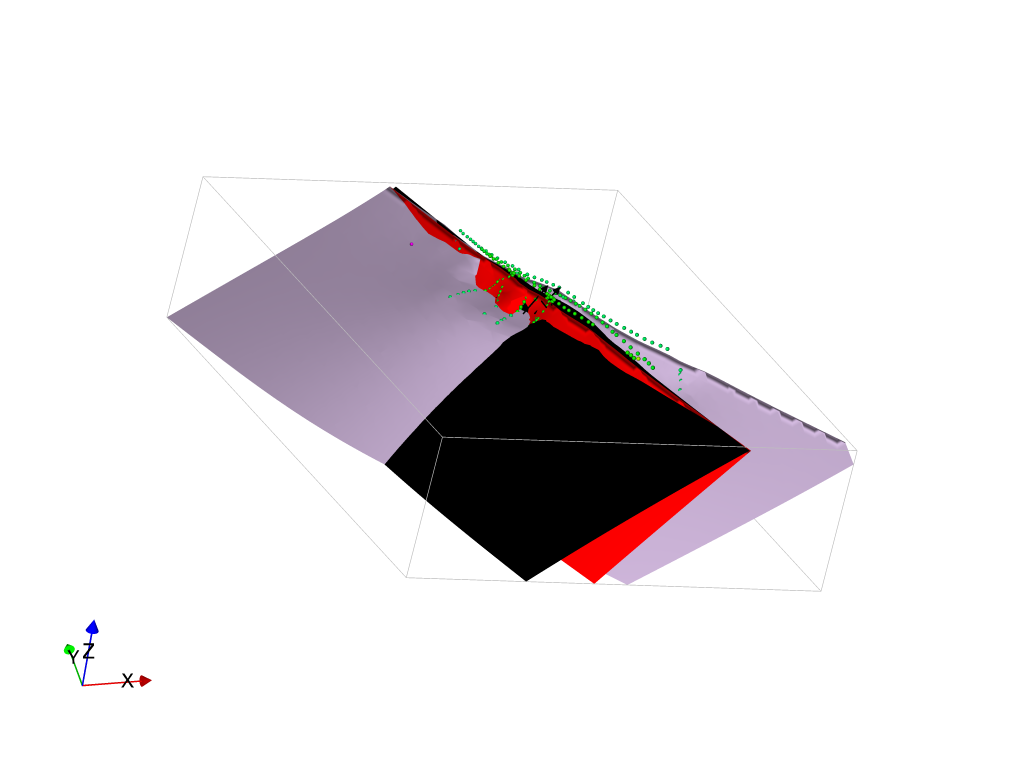

In [62]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_data(model['Boulder Lefroy Fault'], vectors = True)

view.add_isosurface(model['Abattoir East Fault'], colours = ['black'], value = 0)
view.add_data(model['Abattoir East Fault'], vectors = True)

view.add_isosurface(model['Abattoir West Fault'], colours = ['red'], value = 0)
view.add_data(model['Abattoir West Fault'], vectors = True)

# view.interactive()
view.rotation = [-64.54157257080078, 27.872272491455078, -1.8781765699386597]
view.display()

# Add Boorara

In [63]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                            origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)
# model.nsteps = [150, 250, 50]
model.data = processor.data

model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM)  

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, 
                           regularization = [5,5,5])
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])
model.create_and_add_fault('Abattoir East Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
model.create_and_add_fault('Abattoir West Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False)
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 15                     geological features that need to be interpolated



  0%|          | 0/15 [00:00<?, ?it/s]

Model update took: 33.82946801185608 seconds


In [64]:
model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])

In [65]:
model['Abattoir West Fault'].add_abutting_fault(model['Zuleika Fault'])
model['Abattoir East Fault'].add_abutting_fault(model['Zuleika Fault'])

In [66]:
model['Abattoir West Fault'].add_abutting_fault(model['Boorara Fault'])
model['Abattoir East Fault'].add_abutting_fault(model['Boorara Fault'])

Object exists: Boulder Lefroy Fault_value_cp
Object exists: Boulder Lefroy Fault_value_cp
Object exists: Zuleika Fault_value_cp
Object exists: Zuleika Fault_value_cp
Object exists: Abattoir East Fault_value_cp
Object exists: Abattoir East Fault_value_cp
Object exists: Abattoir West Fault_value_cp
Object exists: Abattoir West Fault_value_cp
Object exists: Boorara Fault_value_cp
Object exists: Boorara Fault_value_cp



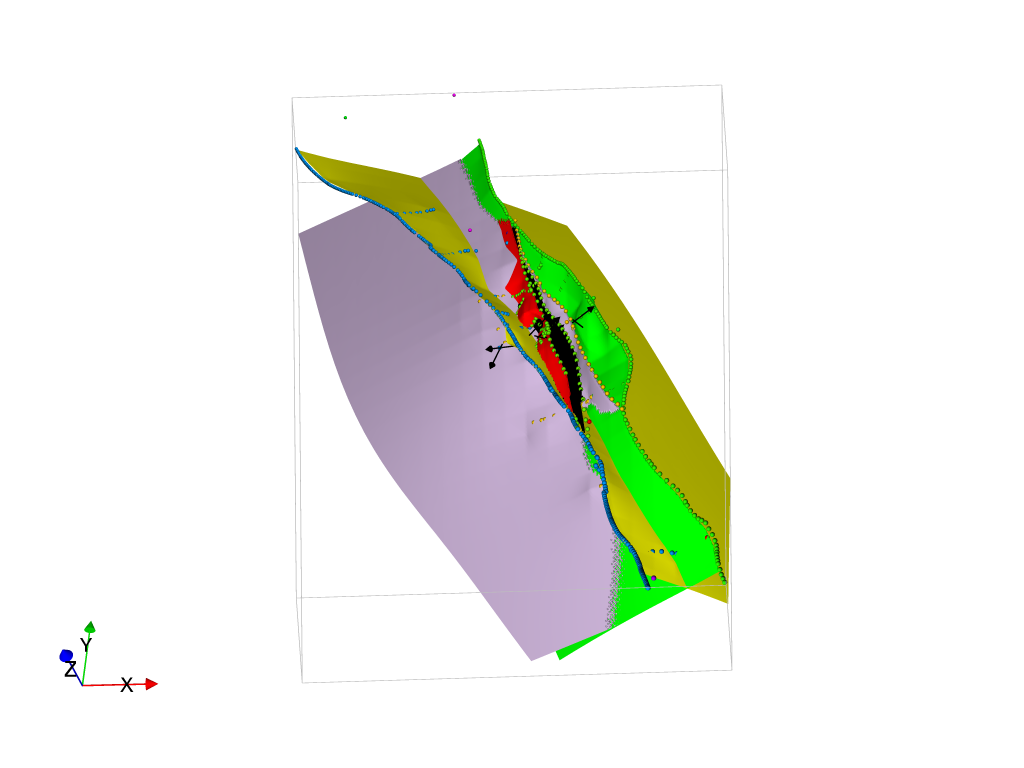

In [73]:
view = LavaVuModelViewer(model)

view.nelements = 1e7

view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)
view.add_data(model['Boulder Lefroy Fault'], vectors = True)

view.add_isosurface(model['Zuleika Fault'], colours = ['yellow'], value = 0)
view.add_data(model['Zuleika Fault'], vectors = True)

view.add_isosurface(model['Abattoir East Fault'], colours = ['black'], value = 0)
view.add_data(model['Abattoir East Fault'], vectors = True)

view.add_isosurface(model['Abattoir West Fault'], colours = ['red'], value = 0)
view.add_data(model['Abattoir West Fault'], vectors = True)

view.add_isosurface(model['Boorara Fault'], colours = ['green'], value = 0)
view.add_data(model['Boorara Fault'], vectors = True)

view.rotation = [-36.196144104003906, -1.6681442260742188, 1.7141367197036743]
view.display()

In [72]:
view.rotation

[-36.196144104003906, -1.6681442260742188, 1.7141367197036743]

In [69]:
updated_ori = updated_ori.reset_index(drop=True)
updated_data = updated_data.reset_index(drop=True)

In [70]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_ori.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)